# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1046]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

X_test, y_test = test['features'], test['labels']

In [1047]:
### To start off let's do a basic data summary.
n_train = X_train.shape[0]

n_test =  X_test.shape[0]

image_shape =  X_train.shape[1:4]

n_classes =  len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


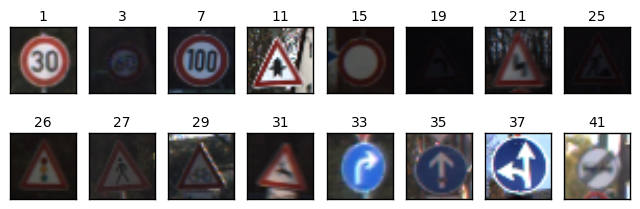

In [1048]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
%matplotlib inline

def show_images(inputs, labels, labels_to_show):
    index = []
    for label in labels_to_show:
        y = np.where(labels==label)
        if len(y[0]) == 0:
            continue
        rnd_index = random.randint(0, len(y[0]))
        index.append(y[0][rnd_index])
    
    # display one random sample of each given label
    rows = (len(index)-1)//8
    fig = plt.figure(figsize=(8, rows+1.5))
    for i in range(len(index)):
        sample = inputs[index[i]]
        ax = fig.add_subplot(rows+1, 8, i+1)
        ax.imshow(sample)
        plt.title(str(labels[index[i]]), fontsize=10)
        ax.axes.get_xaxis().set_visible(False) # hide x tick labels
        ax.axes.get_yaxis().set_visible(False) # hide y tick labels
        
labels_to_show = [1,   3,  7, 11, 15, 19, 21, 25,
                  26, 27, 29, 31, 33, 35, 37, 41]  # specifies which labels to display        
show_images(X_train, y_train, labels_to_show)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1049]:
### Preprocess the data here.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf

# Helper functions

# normalization function
def tensor_normalize(x):
    # new_value = value − min_value / (max_value − min_value)
    with tf.name_scope('normalize') as scope:
        t_min = tf.reduce_min(x)
        t_max = tf.reduce_max(x)
        tensor = tf.div(tf.sub(x, t_min), tf.sub(t_max, t_min))
        tensor = tf.to_float(tensor)
    return tensor

def preprocess(inputs):
    
    # grayscale conversion

    gray = tf.image.rgb_to_grayscale(inputs, name='rgb2gray')
    
    # normalizing input data to fall in [0.0 - 1.0]
    normal = tensor_normalize(gray)
    return normal

def shuffle_data(features, labels):
    idxs = np.arange(0, len(features))
    np.random.shuffle(idxs)
    return [features[idxs], labels[idxs]]
    
def get_variable(name, shape, dtype=tf.float32, trainable=True,
                 initializer=None, stddev=0.01):
    var = tf.get_variable(name, shape, dtype=dtype, trainable=trainable,
                           initializer=initializer)
    return var

def data_iterator(features, labels, batch_size):
    """ A simple data iterator """
    batch_idx = 0
    while True:
    # shuffle labels and features
        idxs = np.arange(0, len(features))
        np.random.shuffle(idxs)
        shuf_features = features[idxs]
        shuf_labels = labels[idxs]
        for batch_idx in range(0, len(features), batch_size):
            images_batch = shuf_features[batch_idx:batch_idx+batch_size]
            labels_batch = shuf_labels[batch_idx:batch_idx+batch_size]
            yield images_batch, labels_batch


### Question 1 

_Describe the techniques used to preprocess the data._

## Preprcessing data
### 1. Grayscale conversion
Here we assume single channel color space is adequate for good recognition rate. So for the sake of less computational resources, we create a tensor for grayscale conversion. 
### 2. Normalization
We observed from a simple test that range is varying from [0-255]. As a part of input preprocessing step, we need to do normalization to map the image range from [0 255] to [0 1]. The resolution does not need to be changed as 32x32 is already a detectable size. We figured out the initial range with a simple test that follows:


In [1129]:
### Test the input range of 10 samples
_ = [print("Input shape:{} - Input Range:[{}-{}]".format(i.shape, i.min(), i.max())) for i in X_train[1:10]]

Input shape:(32, 32, 3) - Input Range:[53-255]
Input shape:(32, 32, 3) - Input Range:[50-255]
Input shape:(32, 32, 3) - Input Range:[37-255]
Input shape:(32, 32, 3) - Input Range:[44-255]
Input shape:(32, 32, 3) - Input Range:[45-255]
Input shape:(32, 32, 3) - Input Range:[6-255]
Input shape:(32, 32, 3) - Input Range:[31-255]
Input shape:(32, 32, 3) - Input Range:[19-255]
Input shape:(32, 32, 3) - Input Range:[36-254]


We propose to employ smaller set for training to keep the training time short. So we need to shuffle our dataset to be able to uniformly include all labels to the new dataset.

In [1051]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
sh_features, sh_labels = shuffle_data(X_train, y_train)

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [1116]:
### Define your architecture here.

# Parameters
learning_rate = 0.001
image_width = 32
image_height = 32
image_depth = 1

# Dropout, probability to keep units
dropout = 0.9 
    
def inference(inputs):
        
    # Store layers weight & bias
    with tf.name_scope('weights') as scope:
        weights = {
            # 3x3 conv, 1 input, 1 outputs
            'wc1': get_variable('wc1', [3, 3, 1, 1],
                                initializer=tf.truncated_normal_initializer(stddev=0.01)),        
            # fully connected, 32*32*1 inputs, 64 outputs
            'wd1': get_variable('wd1', [8*8*1, 64],
                                initializer=tf.truncated_normal_initializer(stddev=0.01)),
            # 64 inputs, n_classes outputs
            'out': get_variable('wo', [64, n_classes],
                                initializer=tf.truncated_normal_initializer(stddev=0.01)),
        }
        
    with tf.name_scope('biases') as scope:
        biases = {
            'bc1': get_variable('bc1', [1], initializer=tf.constant_initializer(0)),
            'bd1': get_variable('bd1', [64], initializer=tf.constant_initializer(0)),
            'out': get_variable('bo', [n_classes], initializer=tf.constant_initializer(0)),
        }
    
    with tf.name_scope('preprocess') as scope:
        processed = preprocess(inputs)
        
    # Convolution Layer
    with tf.name_scope('conv1') as scope:
        conv1 = tf.nn.conv2d(processed, weights['wc1'], strides=[1, 2, 2, 1],
                             padding='SAME')
        conv1 = tf.nn.bias_add(conv1, biases['bc1'])
        conv1 = tf.nn.relu(conv1)
        
    # Max Pooling
    with tf.name_scope('max_pooling') as scope:
        max1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                              padding='SAME')
    
    # Fully connected layer
    with tf.name_scope('fully_connected') as scope:
        # Reshape max1 output to fit fully the connected layer input
        fc1 = tf.reshape(max1, [-1, weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
        fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout, name='dropout')

    # Logits
    with tf.name_scope('output') as scope:
        logits = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    
    return logits

# Loss fucntion and optimizer
def loss_op(logits, labels):
    with tf.name_scope('loss') as scope:
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
                        logits, labels, name='cross_entropy')
        loss_function = tf.reduce_mean(cross_entropy)
        tf.scalar_summary("loss", loss_function)
    return loss_function
    
def trainer(loss):
    with tf.name_scope('train') as scope:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    return optimizer
    
def predict_op(logits):
    with tf.name_scope('predict') as scope:
        # Soft-max logits to a hot vector [None, 43].
        soft = tf.nn.softmax(logits)
        # Select maximal value of softmax layer as predicted value
        predicted = tf.argmax(soft, 1)    
    return predicted
    
def accuracy_op(predicted, labels):
    with tf.name_scope('accuracy') as scope:
        # Evaluate model with its accuracy
        true_positive = tf.equal(tf.cast(predicted, tf.int32), labels)
        acc = tf.reduce_mean(tf.cast(true_positive, tf.float32))
        tf.scalar_summary("accuracy", acc)
    return acc

def initializer():    
    with tf.name_scope('initializer') as scope:
        # Initializing weights and biases
        init = tf.initialize_all_variables()
    return init

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [1117]:
### Train your model here.
# Create a graph
graph = tf.Graph()
# Define the net in graph
with graph.as_default():
    
    # Placeholders for inputs and labels.
    inputs = tf.placeholder(tf.float32,
                            [None, image_width, image_height, image_depth])
    labels = tf.placeholder(tf.int32, [None,])    

    logits = inference(inputs)
    
    loss = loss_op(logits, labels)

    predict = predict_op(logits)
        
    accuracy = accuracy_op(predict, labels)

    train = trainer(loss)    
            
    init = initializer()
    
    # Add histograms for trainable variables.
    for var in tf.trainable_variables():
        tf.histogram_summary(var.op.name, var)
    
    merge_summ_op = tf.merge_all_summaries()

sess = tf.Session(graph=graph)

# Set the logs writer
summary_writer_t = tf.train.SummaryWriter('./logs/'+'train', sess.graph)
summary_writer_v = tf.train.SummaryWriter('./logs/'+'validation', sess.graph)

### Progressive training
We make weights initialization in a separate block to avoid multiple initialization while training. That is because want to perform training step multiple times with different number of samples. This will help us start the training step with smaller dataset and progressively add more dataset to fine tune the weights.

In [1118]:
# initializing weights
sess.run(init)
step = 1

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


In [1125]:
from datetime import datetime, timedelta
from six.moves import xrange 
import os

max_iters = 50000  # maximum number of iterations
valid_size = 2000       # size of validation set
train_size = 15000       # size of training set
batch_size = 128
display_step = 10

train_features = sh_features[valid_size:valid_size + train_size, :, :, 0:image_depth]
train_labels = sh_labels[valid_size:valid_size + train_size]

valid_features = sh_features[0:valid_size, :, :, 0:image_depth]
valid_labels = sh_labels[0:valid_size]

# Train with 5000 smaples for faster training time
train_dict = {inputs:train_features, labels:train_labels}
valid_dict = {inputs:valid_features, labels:valid_labels}


In [ ]:
print("Optimization started...")
start = datetime.now()
#iter_ = data_iterator(X_train, y_train, batch_size)
while step < max_iters:
    #batch_image, batch_label = iter_.__next__()            
    #input_dict = {inputs:batch_image, labels:batch_label}   
    # Run optimization (backprop)
    summary_str, _ = sess.run([merge_summ_op, train], feed_dict=train_dict)
    summary_writer_t.add_summary(summary_str, step)

    if step % display_step == 0:
        # Calculate loss and accuracy
        loss_train, acc_train = sess.run([loss, accuracy], feed_dict=train_dict)
        summary_str_v, loss_valid, acc_valid = sess.run([merge_summ_op, loss, accuracy], feed_dict=valid_dict)
        summary_writer_v.add_summary(summary_str_v, step)
        time = int((datetime.now() - start).total_seconds())
        print("Iter:{}, Elapsed {:02d}:{:02d}:{:02d}, Loss: {:.6f}, "
              "acc_train:%{:.2f}, acc_valid:%{:.2f}".format(step,
              (time//3600), (time%3600)//60, time%60, loss_train,
               acc_train*100, acc_valid*100))
        if acc > 0.98:
            break           
    step += 1
print("Optimization Finished!")

Optimization started...
Iter:5300, Elapsed 00:00:05, Loss: 0.684226, acc_train:%79.00, acc_valid:%74.70
Iter:5310, Elapsed 00:00:19, Loss: 0.681394, acc_train:%79.57, acc_valid:%74.65
Iter:5320, Elapsed 00:00:33, Loss: 0.685835, acc_train:%79.31, acc_valid:%73.65
Iter:5330, Elapsed 00:00:46, Loss: 0.679583, acc_train:%79.53, acc_valid:%74.45
Iter:5340, Elapsed 00:01:00, Loss: 0.676054, acc_train:%79.39, acc_valid:%73.80
Iter:5350, Elapsed 00:01:14, Loss: 0.685279, acc_train:%79.25, acc_valid:%73.60
Iter:5360, Elapsed 00:01:27, Loss: 0.680421, acc_train:%79.15, acc_valid:%73.10
Iter:5370, Elapsed 00:01:41, Loss: 0.671151, acc_train:%79.72, acc_valid:%75.15
Iter:5380, Elapsed 00:01:54, Loss: 0.671745, acc_train:%79.59, acc_valid:%74.05
Iter:5390, Elapsed 00:02:08, Loss: 0.671474, acc_train:%79.81, acc_valid:%74.10
Iter:5400, Elapsed 00:02:22, Loss: 0.673033, acc_train:%79.77, acc_valid:%73.65


**Answer:**

For training we used smaller portion of train set to avoid exhustive training time. For this, we had to keep the size and complexity of the graph relatively small not to get to the overfitting point.

+ As per **optimizer**, **`AdamOptimizer`** was preferred.
+ We used a **batch size** of 5000 samples as a starting point. We progressively added more samples to cover the whole dataset. (Saving memory bandwidth was not crucial)
+ The **learning rate** was `0.001` as a typical value. 
+ For weight initialization we used **`truncated_normal_initializer`** with **`stddev=0.01`**
+ For biases we used **`constant_initializer`** with **`value=0`**
+ **Dropout** factor is selected to be **`0.9`** not to overfit
+ We stop once we reach at least **%98** accuracy

#### Graph topology:
In the following figure we included the graph topology generated by the **tensorboard** visualization tool:

![Graph topolgy](graph.png)


#### Weights Distributions:
Here we include change of sample weights and biases over the course of training time. The bellow figures are visualized by **tensorboard**:
![Weight distributions](dist.png)


#### Weights Histogram:
![Weights histograms](hist.png)

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

The basic approach was by trial and error to find the best performing topology. We started with very simple graph with only one fully connected layer. Then we increased the number of training sample and added more layers/neurons by keep tracking of validation accuracy.

Cross validation and accuracy rate were two role players in finding the best performing graph.

**NOTE:** We are not presenting the most accurate graph here as we want to keep the model small and the training time short for regular PC without GPUs.

The bellow figure shows snapshot of **Loss** and **Accuracy** values over both training and validation sets:
![Loss and Accuracy](loss.png)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

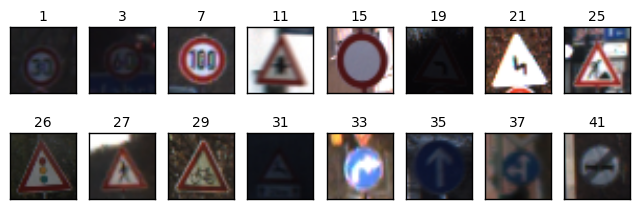

In [1131]:
### Load the images and plot them here.
### Similar to what we have done for the training set

labels_to_show = [1,   3,  7, 11, 15, 19, 21, 25,
                  26, 27, 29, 31, 33, 35, 37, 41]  # specifies which labels to display        
show_images(X_test, y_test, labels_to_show)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
+ It seems that samples with dark lighting conditions are more prone to misclassification. We can handle this effect to some extent by adding more samples with random contrast level. 
+ Low resolution samples are next erroneous ones. 
+ Shadows are the other limiting factor for recognition rate

Accuracy over the test set: %61.12
Labels:     [35 12  3 10  1 14 25 12  5 13 18 25 12  3 10]
Predicted:  [35 12  7 10  1 14 25 12  5 13 18 25 12  3 10]


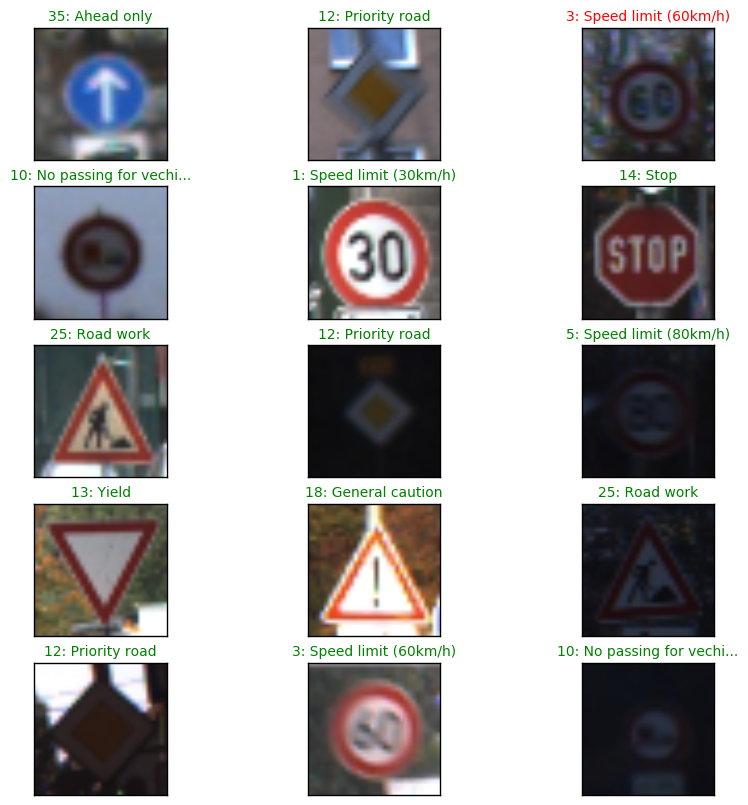

In [1132]:
### Run the predictions here.
# Pick 15 random test samples
num_test = 15
test_features, test_labels = shuffle_data(X_test, y_test)

input_dict = {inputs:test_features[:,:,:, 0:image_depth], labels:test_labels}   

predicted, acc = sess.run([predict, accuracy], feed_dict=input_dict)

print("Accuracy over the test set: %{:.2f}".format(acc*100))
print("Labels:    ", test_labels[0:num_test])
print("Predicted: ", predicted[0:num_test])

with open("signnames.csv", 'r') as f:
    sign_name = {row.split(',')[0] : row.split(',')[1] for row in f}

def visualize_prediction(inputs, labels, pred_labels):
    # display one random sample of each given label
    rows = (len(inputs)-1)//3
    fig = plt.figure(figsize=(10, rows+10))
    col = 1
    for i in range(len(inputs)):
        ax = fig.add_subplot(rows+3, 3, col)
        col += 1
        ax.imshow(inputs[i])
        text = sign_name[str(labels[i])]
        # limit the text length up to 25 chars and remove null-terminating end
        text = text[0:20] + "..." if len(text)>25 else text[0:len(text)-1]
        plt.title(str(labels[i]) + ": " +  text, fontsize=10,
                  color='green' if labels[i] == pred_labels[i] else 'red')
        ax.axes.get_xaxis().set_visible(False) # hide x tick labels
        ax.axes.get_yaxis().set_visible(False) # hide y tick labels

visualize_prediction(test_features[0:num_test], test_labels[0:num_test], predicted[0:num_test])


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


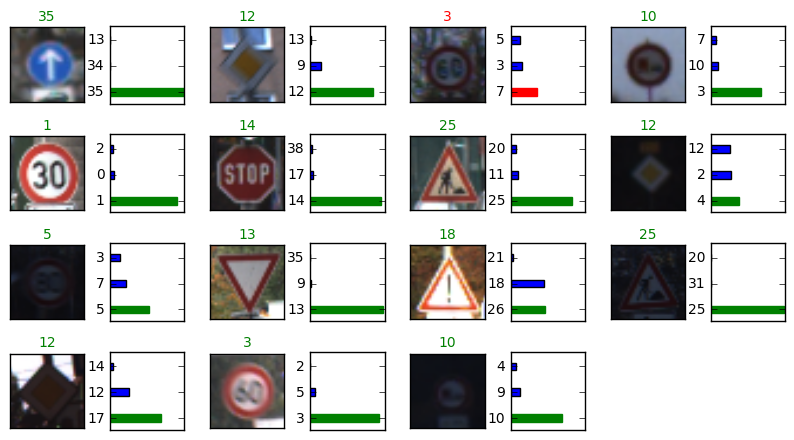

In [1133]:
### Visualize the softmax probabilities here. 
k = 3
num_test = 15

soft = tf.nn.softmax(logits)
probability = sess.run(soft, feed_dict=input_dict)
prob = np.squeeze(probability[0:num_test])

rows = (2*num_test-1)//4
col = 0
fig = plt.figure(figsize=(10, rows+4))
for i in range(num_test):
    prob_idx = prob.argsort()[i][::-1]
    top_k_idx = prob_idx[0:k]

    ax = fig.add_subplot(rows+1, 8, col+1)
    ax.imshow(test_features[i])
    plt.title(str(test_labels[i]), fontsize=10,
              color='green' if test_labels[i] == predicted[i] else 'red')
    ax.axes.get_xaxis().set_visible(False) # hide x tick labels
    ax.axes.get_yaxis().set_visible(False) # hide y tick labels
    
    col += 1
    ax = fig.add_subplot(rows+1, 8, col+1)
    ind = np.arange(k)
    width = 0.3
    barlist = ax.barh(width+ind, prob[i][top_k_idx],width)
    ax.set_aspect(0.35)
    ax.axis([0, 1, 0, k])
    barlist[0].set_color('g' if test_labels[i] == predicted[i] else 'r')
    plt.yticks(ind + 1.5*width, top_k_idx)
    fig.subplots_adjust(wspace=0.35)

    ax.axes.get_xaxis().set_visible(False) # hide x tick labels
    col += 1

# Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

It is observed that in most cases the next high probability value is the correct label. However, this statement is not always true. 

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.